In [1]:
import networkx as nx
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from random import random

In [2]:
class maxcut():
    def __init__(self, matrix):
        self.graph = nx.Graph()
        self.graph.add_nodes_from(list(range(0,len(matrix))))
        self.matrix = matrix
        for i in range(0, len(matrix)):
            for j in range(0,len(matrix[i])):
                if(matrix[i][j] == 1):
                    self.graph.add_edges_from([(i, j)])
    
    def get_matrix(self):
        return self.matrix
    
    def get_graph(self):
        return self.graph

    def get_cost(self, cut):
        cost = 0
        for i, j in self.graph.edges():
            if cut[i] != cut[j]:
                cost -= 1
        return cost

    def print_graph(self):
        nx.draw(self.graph, with_labels=True, alpha=0.8, node_size=500)

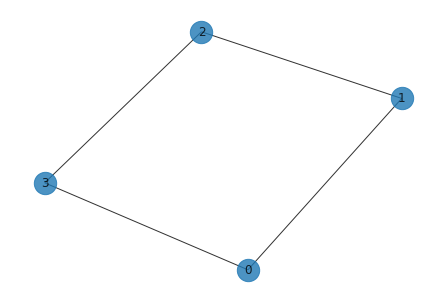

In [3]:
maxc = maxcut([[0,1,0,1],[1,0,1,0],[0,1,0,1],[1,0,1,0]])
maxc.print_graph()

In [6]:
class anzats():
    def __init__(self, maxc):
        graph = maxc.get_graph()
        numqubits = 4
        self.circuit = QuantumCircuit(numqubits)
        self.maxcut = maxc
        for i in range(0, numqubits):
            self.circuit.h(i)
        gamma = Parameter("gamma")
        for nodes in list(graph.edges()): 
            self.circuit.rzz(2 * gamma, nodes[0], nodes[1])
        beta = Parameter("beta")
        for i in range(0,numqubits):
            self.circuit.rx(2 * beta, i)

    def output_circuit(self, params):
        backend = Aer.get_backend('qasm_simulator')
        backend.shots = 1000
        qc_res = self.circuit.copy()
        qc_res = qc_res.bind_parameters(params)
        qc_res.measure_all()
        counts = backend.run(qc_res).result().get_counts()
        return counts

    def get_expectation(self,params):
        backend = Aer.get_backend('qasm_simulator')
        qc = self.circuit.copy()
        qc = qc.bind_parameters(params)
        qc.measure_all()
        counts = backend.run(qc, nshots=1000).result().get_counts()
        avg = 0
        sum_count = 0
        for bitstring, count in counts.items():
            obj = self.maxcut.get_cost(bitstring)
            avg += obj * count
            sum_count += count
        return avg/sum_count

    def optimize_classic(self, init_point):
        expectation = self.get_expectation
        res = minimize(expectation, init_point, method='COBYLA')
        return res

    def get_gbest(self,particles):
        best = particles[0]["pbest"]
        for i in range(0,len(particles)):
            if(particles[i]["pbest"][2] < best[2]):
                best = particles[i]["pbest"]
        return best

    def optimize_PSO(self, w,c1,c2,r1,r2, num_particles, num_iterations):
        particles_position = list()
        for _ in range(0, num_particles):
            x = random()
            y = random()
            z = self.get_expectation([x,y])
            particles_position.append(dict({"x":x,"y":y,"z":z, "pbest": [x,y,z]}))
        particles_velocity = list()
        for _ in range(0, num_particles):
            vx = random()
            vy = random()
            vz = random()
            particles_velocity.append(dict({"vx":vx,"vy":vy,"vz":vz}))
        for _ in range(0, num_iterations):
            for particle in range (0, num_particles):
                new_position_x = particles_position[particle]["x"] + particles_velocity[particle]["vx"]
                new_position_y = particles_position[particle]["y"]+ particles_velocity[particle]["vy"]
                new_position_z = particles_position[particle]["z"] + particles_velocity[particle]["vz"]
                if(new_position_z < particles_position[particle]["pbest"][2]):
                    particles_position[particle]["pbest"][0] = new_position_x
                    particles_position[particle]["pbest"][1] = new_position_y
                    particles_position[particle]["pbest"][2] = new_position_z
                particles_position[particle]["x"] = new_position_x
                particles_position[particle]["y"] = new_position_y
                particles_position[particle]["z"] = new_position_z
                bestPosition = self.get_gbest(particles_position)
                particles_velocity[particle]["vx"] = w*particles_velocity[particle]["vx"] + c1*r1*(particles_position[particle]["pbest"][0]-particles_position[particle]["x"]) + c2*r2*(bestPosition[0]-particles_position[particle]["x"])
                particles_velocity[particle]["vy"] = w*particles_velocity[particle]["vy"] + c1*r1*(particles_position[particle]["pbest"][1]-particles_position[particle]["y"]) + c2*r2*(bestPosition[1]-particles_position[particle]["y"])
                particles_velocity[particle]["vz"] = w*particles_velocity[particle]["vz"] + c1*r1*(particles_position[particle]["pbest"][2]-particles_position[particle]["z"]) + c2*r2*(bestPosition[2]-particles_position[particle]["z"])
        return self.get_gbest(particles_position)
        

In [7]:
myanzats = anzats(maxc)
myanzats.optimize_classic([1.0, 1.0])

     fun: -2.923828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([2.04773611, 1.24991198])

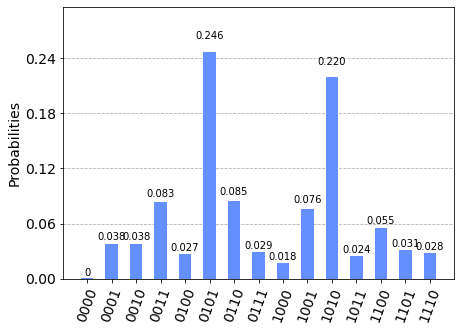

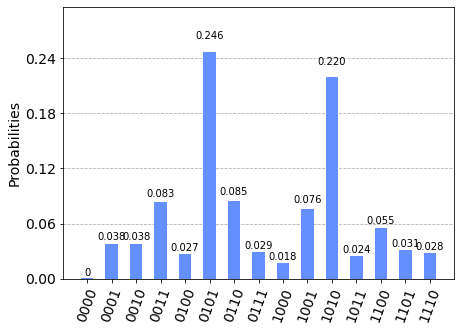

In [8]:
plot_histogram(myanzats.output_circuit([2.83423101, 3.4549987 ]))

In [13]:
myanzats.optimize_PSO(0.5,0.1,0.1,3,2, 50,  100)

[0.3472229534032578, 0.5894798915442027, -3.0730088603079517]

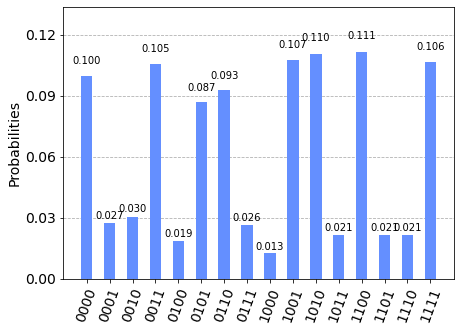

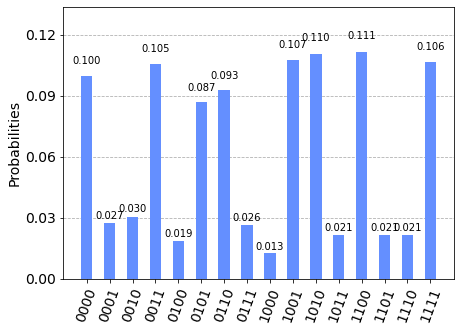

In [14]:
plot_histogram(myanzats.output_circuit([0.2339812774798776, 0.7839192609310407 ]))

In [15]:
myanzats = anzats(maxc)
myanzats.optimize_classic([0.3472229534032578, 0.5894798915442027])

     fun: -3.009765625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([1.1906992 , 0.43002344])

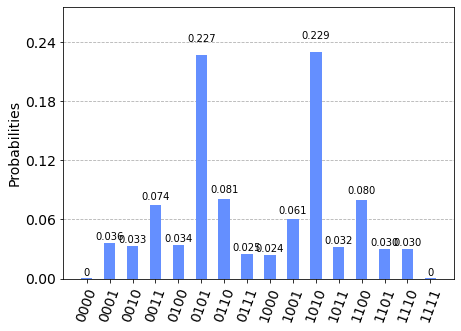

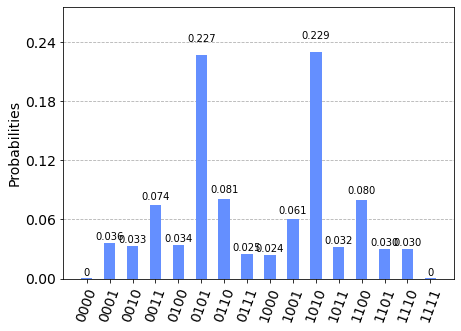

In [16]:
plot_histogram(myanzats.output_circuit([2.83423101, 3.4549987 ]))